NOTE: This notebook is for presentation purposes.
<br>
While this notebook presents the final model as the last section,
previous sections are related to the final prediction.
This notebook includes many immature ideas and experiments and therefore takes a long time to run.
<br>
To evaluate the performance of the final model (on holdout data),
please use the other notebook (Final_project.ipynb).

In [1]:
NAME = "Guangyu (Hubert) Wang"
COLLABORATORS = ""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, multilabel_confusion_matrix

import helper
helper = helper.Helper()



# Get the Data
The raw data are presented in the form of .csv files. Here I define a function to
extract useful information from a specific file. This function will be reused repeatedly
in the following sections.

In [2]:
def get_data_from_csv(_ticker : str, _folder='train') -> pd.DataFrame:
    """
    :param _ticker: the name of the file to convert
    :param _folder:
    :return: a tuple containing an array of data and an array of daily returns
    """
    _data = pd.read_csv('Data/'+_folder+'/'+_ticker + '.csv', index_col='Dt')
    _data['Ret'] = _data["Adj Close"].pct_change()
    _data.dropna(how='any', inplace=True)
    return _data['Ret']

def generate_sample(return_df : pd.DataFrame, block_size: int, offset=0) -> tuple:
    _return_vec = np.asarray(return_df)
    X = []
    y = []
    i = offset
    while i < (_return_vec.size - block_size-2):
        X.append(_return_vec[i:(i+block_size)])
        y.append(np.average(_return_vec[i+block_size:i+block_size+5]))
        i += 5
    return np.asarray(X), y


data_rua = get_data_from_csv('RUA')
data_rua.head()
# X, y = generate_sample(data_rua,22)

Dt
2/21/1995   -0.000156
2/22/1995    0.004406
2/23/1995    0.004777
2/24/1995    0.001705
2/27/1995   -0.008110
Name: Ret, dtype: float64

# Explanatory Data Analysis (EDA)

## What I found
Let's first take a look at the data in histogram.

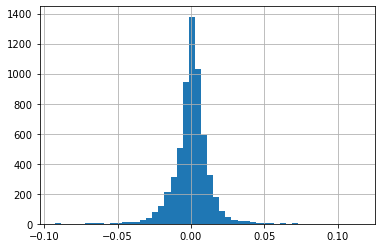

In [3]:
data_rua.hist(bins=50)

mean:  0.0003122816898796789 , var: 0.011610053811616571
Data kurtosis:  6.186054279540274


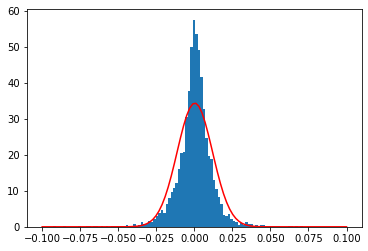

In [4]:
data_rua= data_rua.loc[-.10 < data_rua]
data_rua= data_rua.loc[ data_rua< .10 ]
data_rua.describe()
# data_rua.hist(bins=100)
mean, var  = scipy.stats.distributions.norm.fit(data_rua)
print("mean: ", mean, ", var:", var)
x = np.linspace(-.10,.10,100)
fitted_rua= scipy.stats.distributions.norm.pdf(x, mean, var)
plt.hist(data_rua, density=True, bins=100)
plt.plot(x,fitted_rua,'r-')
print("Data kurtosis: ", data_rua.kurtosis())

The distribution appears to be a Leptokurtic distribution with very high kurtosis.

Let's try fitting it with a student t distribution instead

Degree of Freedom:  2.8485318087435036 Loc:  0.0006877632788916586 Scale:  0.007160476493360792


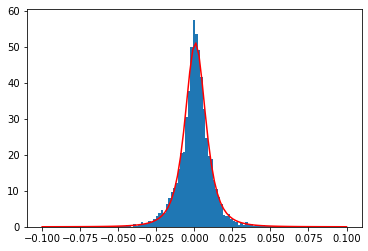

In [5]:
t_df, t_loc, t_scale = scipy.stats.distributions.t.fit(data_rua)
fitted_rua = scipy.stats.distributions.t.pdf(x, t_df, loc=t_loc, scale=t_scale)
plt.hist(data_rua, density=True, bins=100)
plt.plot(x,fitted_rua,'r-')
print("Degree of Freedom: ", t_df, "Loc: ", t_loc, "Scale: ", t_scale)

This is more like it! Although the student-t distribution used here is not very
explanatory of the data distribution we are fitting, we can now get a general
idea of what our predictions should look like.


## What am I going to do with this distribution.
The reason to look for a distribution that fits well with Apple stock prices is
the lack of training data - if we only use returns of RUA returns, we will only have
less than 800 samples (22 returns each, plus one as label; gap = 5 trading days). This is far from enough
to train a complicated neural network model.

The best way to deal with this problem, in my opinion, is to **synthesize data** using
returns of other stocks.

Take Microsoft for example

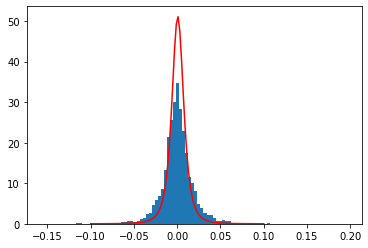

In [6]:
data_msft = get_data_from_csv('MSFT')
data_msft  = data_msft.loc[-.2 < data_msft ]
data_msft = data_msft.loc[ data_msft < .2 ]
data_msft.describe()
plt.hist(data_msft, density=True, bins=100)
plt.plot(x,fitted_rua,'r-') # This is the fitted t-distribution for RUA

As we can see from the plot above, the distribution of Microsoft stock returns
is significantly different from that of Russel 3000 - Microsoft returns seems to have
a larger spread, indicating a higher variance. 

If we were to fit the actual t-distribution, we will have smaller "loc" and "scale"
parameters.

Degree of Freedom:  2.702612456259764 Loc:  8.426161300835008e-05 Scale:  0.011561145020321233


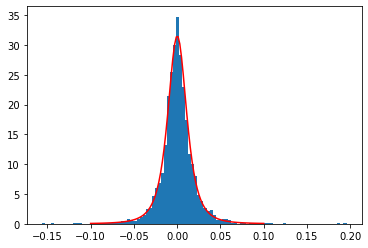

In [7]:
t_df, t_loc, t_scale = scipy.stats.distributions.t.fit(data_msft)
fitted_msft = scipy.stats.distributions.t.pdf(x, t_df, loc=t_loc, scale=t_scale)
plt.hist(data_msft, density=True, bins=100)
plt.plot(x,fitted_msft,'r-')
print("Degree of Freedom: ", t_df, "Loc: ", t_loc, "Scale: ", t_scale)

It is noteworthy, however, that the fitted "Degree of Freedom" is relatively similar.
As fitting stock returns to a student-t distribution is not very reasonable in itself,
we might just leave the kurtosis problem aside and just focus on the problem of mean
and variance.

Does it work if we just "re-mean" and "re-variance" the microsoft stock returns?


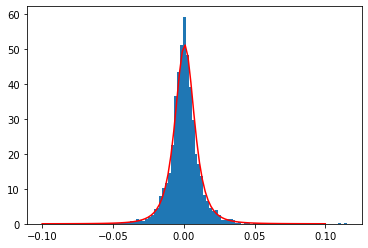

In [8]:
data_msft_reshaped = (data_msft - np.mean(data_msft)) / np.std(data_msft) * np.std(data_rua) + np.mean(data_rua)
plt.hist(data_msft_reshaped, density=True, bins=100)
plt.plot(x,fitted_rua,'r-')    # This is the fitted t-distribution for RUA

It works! All I did is simply to match the mean and variance of the two distributions,
and the MSFT returns distribution looks pretty much the same as AAPL.

To make sure that it is not a fluke, let us try another example, GOOG



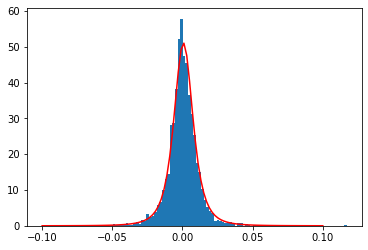

In [9]:
data_goog = get_data_from_csv('GOOG')
data_goog = data_goog.loc[-.2 < data_goog ]
data_goog = data_goog.loc[ data_goog < .2 ]
data_goog_reshaped = (data_goog - np.mean(data_goog)) / np.std(data_goog) * np.std(data_rua) + np.mean(data_rua)
plt.hist(data_goog_reshaped, density=True, bins=100)
plt.plot(x,fitted_rua,'r-')    # This is the fitted t-distribution for AAPL


It also works. That seems to be a handy way of generate synthesized data for Apple
stock returns. Let's wrap it up in a new function then.

In [10]:
def synthesize_sample_from_csv_list(ticker_list : list) -> tuple:
    offset = 0
    X_result, y_result = generate_sample(data_rua, 22) # Initialize with genuine Apple sample
    X_result = np.asarray(X_result)
    y_result = np.asarray(y_result)
    for ticker_i in ticker_list: # Add synthesized data
        offset += 2 # prevent correlation between test samples
        data_i = get_data_from_csv(ticker_i)
        data_i = data_i.loc[-.25 < data_i ]
        data_i = data_i.loc[ data_i < .25 ]
        data_i_reshaped = data_i - np.mean(data_i) + np.mean(data_rua)
        data_i_reshaped = data_i_reshaped / np.std(data_i) * np.std(data_rua)
        plt.hist(data_i_reshaped, density=True, bins=100, alpha=0.2)
        X_i, y_i = generate_sample(data_i_reshaped, 22, offset=offset)
        X_result = np.concatenate([X_result, X_i])
        y_result = np.concatenate([y_result, y_i])
#     plt.plot(x,fitted_rua,'r-')
    return X_result, y_result

# test_ticker_list = ['ADBE', 'CRM', 'CSCO', 'FB', 'GOOG', 'IBM', 'INTC', 'NVDA']
test_ticker_list = []
X_sample, y_sample = synthesize_sample_from_csv_list(test_ticker_list)
print("X_sample shape: ", X_sample.shape, ", y_sample shape:", y_sample.shape)

X_sample shape:  (1197, 22) , y_sample shape: (1197,)


A different "offset" is applied to different tickers so that the samples will not be split on exactly the same dates
(which results in similar sample patterns).

Now we have more than 6000 samples to play with. Hopefully this will prove enough for training
purposes.

To be clear, all the data included here serve as synthesized Russel Index returns - my model will
train on these data assuming these "are" genuine RUA returns.

For the out-sample testing (holdout data), **only** real "RUA" data will be used.

# Define Performance Measures

Let us get down to the fundamentals and agree that predicting stock returns is very hard. There are so many
uncertainties in the stock market that a confident and accurate forecast is all but impossible.
If we were to approach this project as a regression problem, we will certainly get inaccurate predictions
which are close to zero because any attempt to generate abnormal (either high or low) daily returns will
subject to severe punishment in the loss function.

A slightly more practicable approach, in my opinion, is to approach this task as a **classification task** --
our model will attempt to generate a signal for the day to be predicted, and we are satisfied as long
as the signal turns out to be profitable.

Specifically, we will divide sample labels into three categories:
- Daily returns > +0.8%, which are labeled "Buy"
- Daily returns < -0.8%, which are labeled "Sell"
- Returns between $\pm$ 0.8%, which are labeled "Hold"

The idea behind this trichotomy (instead a simple dichotomy of "Buy" and "Sell") is to avoid overfitting.
When the returns are close to zero, the moving directions are no more than random noises that should not
be categorized as either "Buy" or "Sell".

Specifically, we choose 0.8% as the dividing point because this splits the data into three groups that
are roughly equal in size. If my algorithm blindly spams the largest group ("Hold"), it will have a 
win rate of around 36.6%.

To be clear, this classification only applies to the labels (y). The input data (X) will maintain the form
of numerical values (daily returns).

In [11]:
print("Total: ", len(y_sample))
print("Buy: ", len(y_sample[y_sample > 0.00225]))
print("Sell: ", len(y_sample[y_sample < -0.00105]))
print("Hold: ", len(y_sample[(y_sample >= -0.00105) & (y_sample <= 0.00225)]))

Total:  1197
Buy:  402
Sell:  397
Hold:  398


# Prepare the Data
Using the method introduced above, we shall transform the returns to be predicted into categorical
signals, using one-hot encoding.

In [12]:
def generate_signals_from_returns(x_returns):
    cat = []
    for r in x_returns:
        if r > 0.00225:
            cat.append(2)
        elif r < -0.00105:
            cat.append(0)
        else:
            cat.append(1)
    cat = pd.DataFrame(cat)
    return cat

y_sample = generate_signals_from_returns(y_sample)
y_signal = to_categorical(y_sample)
print(y_sample[:5])
print(y_signal[:5])

   0
0  2
1  1
2  1
3  0
4  2
[[0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


We then split data into train, valid, and test, and then transform the input into
the 3-dimensional shape (batchsize, timesteps, dimensionality).

In [13]:
y_signal = np.asarray(y_signal)
X_in, X_test, y_in, y_test = train_test_split(X_sample, y_signal, test_size=0.10, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_in, y_in, test_size=0.20, random_state=42)
X_train = X_train.reshape([-1, 22, 1])
X_valid = X_valid.reshape([-1, 22, 1])
X_test = X_test.reshape([-1, 22, 1])


# Models and Experiments

## Multi-layer RNN Model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 22, 10)            120       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 22, 10)            210       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 10)                210       
_________________________________________________________________
dense (Dense)                (None, 3)                 33        
Total params: 573
Trainable params: 573
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
27/27 [==============================] - 1s 29ms/step - loss: 1.1016 - accuracy: 0.3415 - val_loss: 1.1028 - val_accuracy: 0.3287
Epoch 2/20
27/27 [==============================] - 0s 7ms/step - loss: 1.0977 - accuracy: 0.3542 - val_loss: 1.100

(<Figure size 864x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000026CB9500308>,
       dtype=object))

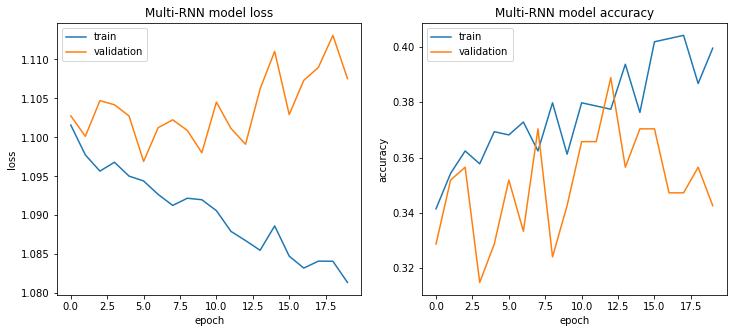

In [14]:
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(10, return_sequences=True, input_shape=[22, 1]),
    tf.keras.layers.SimpleRNN(10, return_sequences=True),
    tf.keras.layers.SimpleRNN(10),
    tf.keras.layers.Dense(3, activation='softmax')
])

model_1.summary()
model_1.compile(loss='categorical_crossentropy', metrics='accuracy', optimizer='adam')
history_1 = model_1.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
helper.plotTrain(history_1, 'Multi-RNN')

Let's try stacking even more RNN layers.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 22, 10)            120       
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 22, 10)            210       
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 22, 10)            210       
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 22, 15)            390       
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 22, 15)            465       
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 15)                465       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                

(<Figure size 864x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000026CC4FDEB08>,
       dtype=object))

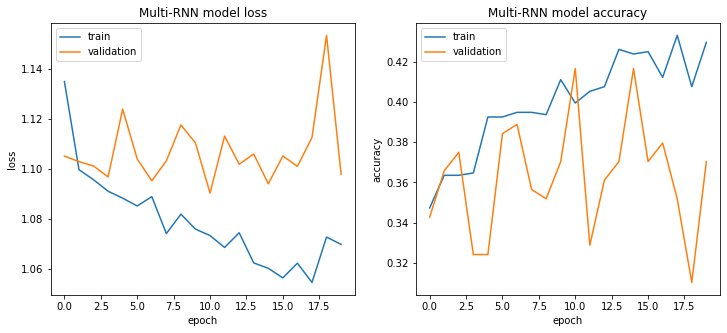

In [15]:
model_2 = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(10, return_sequences=True, input_shape=[22, 1]),
    tf.keras.layers.SimpleRNN(10, return_sequences=True),
    tf.keras.layers.SimpleRNN(10, return_sequences=True),
    tf.keras.layers.SimpleRNN(15, return_sequences=True),
    tf.keras.layers.SimpleRNN(15, return_sequences=True),
    tf.keras.layers.SimpleRNN(15),
    tf.keras.layers.Dense(3, activation='softmax')
])

model_2.summary()
model_2.compile(loss='categorical_crossentropy', metrics='accuracy', optimizer='adam')
history_2 = model_2.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
helper.plotTrain(history_2, 'Multi-RNN')


The performances of test samples continues to improve, but the improvement is
far less significant than the growth in the number of parameters. The validation
scores also seem to stagnate in the last few epochs, showing some evidence of
over-fitting.

A new framework is needed to further improve the result

## LSTM Model
In this section we will implement a Long short-term memory (LSTM)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 22, 10)            480       
_________________________________________________________________
lstm_1 (LSTM)                (None, 22, 10)            840       
_________________________________________________________________
dropout (Dropout)            (None, 22, 10)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 22, 10)            840       
_________________________________________________________________
lstm_3 (LSTM)                (None, 10)                840       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 33        
Total params: 3,033
Trainable params: 3,033
Non-trainable params: 0
____________________________________________________

(<Figure size 864x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000026CC6E14688>,
       dtype=object))

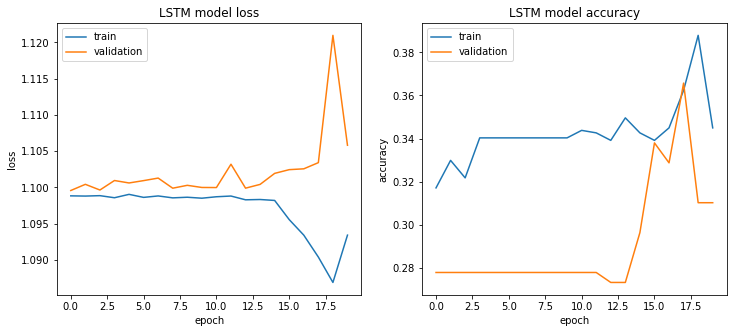

In [16]:
model_3 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(10, return_sequences=True, input_shape=[22, 1]),
    tf.keras.layers.LSTM(10, return_sequences=True),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.LSTM(10, return_sequences=True),
    tf.keras.layers.LSTM(10),
    tf.keras.layers.Dense(3, activation='softmax')
])

model_3.summary()
model_3.compile(loss='categorical_crossentropy', metrics='accuracy', optimizer='adam')
history_3 = model_3.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
helper.plotTrain(history_3, 'LSTM')

This is even worse then what we had before. Maybe we just need more layers?

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 22, 10)            480       
_________________________________________________________________
lstm_5 (LSTM)                (None, 22, 10)            840       
_________________________________________________________________
lstm_6 (LSTM)                (None, 22, 10)            840       
_________________________________________________________________
lstm_7 (LSTM)                (None, 22, 15)            1560      
_________________________________________________________________
lstm_8 (LSTM)                (None, 22, 15)            1860      
_________________________________________________________________
lstm_9 (LSTM)                (None, 15)                1860      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                

(<Figure size 864x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000026CD7F61448>,
       dtype=object))

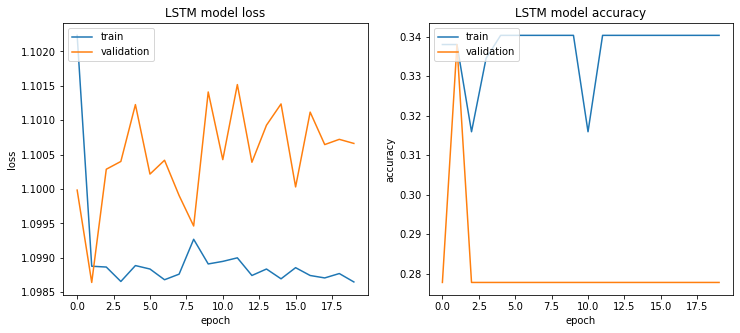

In [17]:
model_4 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(10, return_sequences=True, input_shape=[22, 1]),
    tf.keras.layers.LSTM(10, return_sequences=True),
    tf.keras.layers.LSTM(10, return_sequences=True),
    tf.keras.layers.LSTM(15, return_sequences=True),
    tf.keras.layers.LSTM(15, return_sequences=True),
    tf.keras.layers.LSTM(15),
    tf.keras.layers.Dense(3, activation='softmax')
])

model_4.summary()
model_4.compile(loss='categorical_crossentropy', metrics='accuracy', optimizer='adam')
history_4 = model_4.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
helper.plotTrain(history_4, 'LSTM')

## Save the final model


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 20, 10)            40        
_________________________________________________________________
gru (GRU)                    (None, 20, 10)            660       
_________________________________________________________________
gru_1 (GRU)                  (None, 20, 10)            660       
_________________________________________________________________
gru_2 (GRU)                  (None, 20, 10)            660       
_________________________________________________________________
gru_3 (GRU)                  (None, 10)                660       
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 33        
Total params: 2,713
Trainable params: 2,713
Non-trainable params: 0
____________________________________________________

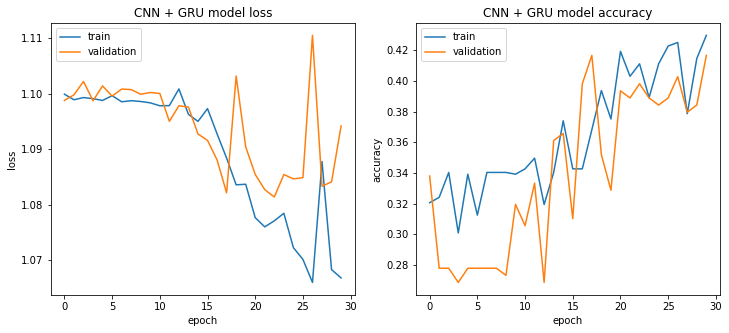

In [18]:
import os
from tensorflow.keras.models import load_model

model_final = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=10, kernel_size=3, strides=1, padding='valid', input_shape=[22,1]),
    tf.keras.layers.GRU(10, return_sequences=True, input_shape=[22, 1]),
    tf.keras.layers.GRU(10, return_sequences=True),
    tf.keras.layers.GRU(10, return_sequences=True),
    tf.keras.layers.GRU(10),
    tf.keras.layers.Dense(3, activation='softmax')
])

model_final.summary()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model_final.compile(loss='categorical_crossentropy', metrics='accuracy', optimizer='adam')
history_final = model_final.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), callbacks=[callback])
helper.plotTrain(history_final, 'CNN + GRU')

# Save to local file
modelName = "final_model"
model_path = os.path.join(".", modelName)

def saveModel(model, model_path):
    try:
        os.makedirs(model_path)
    except OSError:
        print("Directory {dir:s} already exists, files will be over-written.".format(dir=model_path))

    # Save JSON config to disk
    json_config = model.to_json()
    with open(os.path.join(model_path, 'config.json'), 'w') as json_file:
        json_file.write(json_config)
    # Save weights to disk
    model.save_weights(os.path.join(model_path, 'weights.h5'))

    print("Model saved in directory {dir:s}; create an archive of this directory and submit with your assignment.".format(dir=model_path))

saveModel(model_final, model_path)


# Conversion and Evaluation
First, load the model we just created

In [27]:
def loadModel(model_path):
    # Reload the model from the 2 files we saved
    with open(os.path.join(model_path, 'config.json')) as json_file:
        json_config = json_file.read()
    model = tf.keras.models.model_from_json(json_config)
    model.load_weights(os.path.join(model_path, 'weights.h5'))

    return model

model_test = loadModel(model_path)


Then use the model to create a prediction on the test dataset

In [28]:
data_backtest = get_data_from_csv('RUA', _folder='sample')
X_backtest, y_backtest = generate_sample(data_backtest, 1)
y_pred_softmax = model_test.predict(X_test)
print(y_pred_softmax[:5])

[[0.3930834  0.18448463 0.42243195]
 [0.38542637 0.13598135 0.47859225]
 [0.4091621  0.20042874 0.39040914]
 [0.41259688 0.1653937  0.42200938]
 [0.37090313 0.3046639  0.32443294]]


The result is in the form of a softmax matrix, but we will need it in classes (one-hot encoding) to
see the final accuracy score



In [29]:
y_pred_label = np.argmax(y_pred_softmax, axis=1)
print(y_pred_label[:5])
y_pred_ohe = to_categorical(y_pred_label)
print("Accuracy: ", accuracy_score(y_test, y_pred_ohe))
print("\nMultilabel Confusion Matrix:")
print(multilabel_confusion_matrix(y_test, y_pred_ohe))
print("\nFor reference, a perfect prediction will be:")
print(multilabel_confusion_matrix(y_test, y_test))

[2 2 0 2 0]
Accuracy:  0.35833333333333334

Multilabel Confusion Matrix:
[[[40 36]
  [26 18]]

 [[56 25]
  [26 13]]

 [[67 16]
  [25 12]]]

For reference, a perfect prediction will be:
[[[76  0]
  [ 0 44]]

 [[81  0]
  [ 0 39]]

 [[83  0]
  [ 0 37]]]


Finally, our task is to predict **Return**, not classes. We use the following function
to transform signals of Buy/Sell/Hold into returns of numeric values.

The algorithm is quite simple:
- For "Buy", we predict the next return will be positive
and the value is the standard deviation of the test sample (+1 std);
- For "Sell", we predict the next return will be negative (-1 std);
- For "Hold", we predict $\pm$ 1 std based on the probability of "Buy/Sell" from the
softmax matrix

Note that the std is always calculated with monthly data **before** the day to
predict, therefore it is not cheating.

The idea behind this transformation is that, in experience, the volatility of a certain
stock will be relatively stable in a short period of time. If we have a direction, we just
predict in that direction; when the model is indecisive, we do not predict anything.

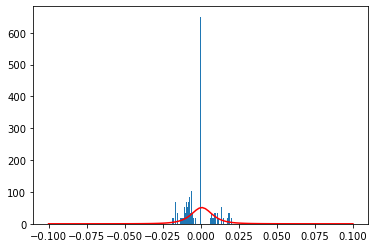

In [30]:
def get_std_from_sample(x_mat):
    std_vec = []
    for x in x_mat:
        std_vec.append(np.std(x))
    return std_vec

def get_returns_from_signal(label_vec, softmax_mat, std_vec):
    returns_vec = (label_vec - 1) * std_vec
#     for i in range(len(returns_vec)):
#         if(returns_vec[i] == 0.):
#             soft_row = softmax_mat[i]
#             if soft_row[2] > soft_row[0] +0.052: # 0.052 is a hyperparameter to make the split more even 
#                 returns_vec[i] = 1. * std_vec[i]
#             else: 
#                 returns_vec[i] = - 1. * std_vec[i]
    return returns_vec

x_std = get_std_from_sample(X_test)
y_pred_ret = get_returns_from_signal(y_pred_label, y_pred_softmax, x_std)
plt.hist(y_pred_ret, density=True, bins=100)
plt.plot(x,fitted_rua,'r-')

## A test on holdout data

Let's generate some returns on the holdout (sample) dataset.

**NOTE**: The id of predictions will be shorter than the all the dates available
because we cannot make predictions on the first 22 days. We also do not predict the
day after the last day (even if we are able to do so).

To be sure, the result will be corresponding
to all actual returns **except the first 22 days**.

6763
6763
<bound method NDFrame.head of            Adj Close        Volume    SMAVG (15)  state
Dt                                                     
3/23/1995    282.079  4.507555e+08  4.403001e+08      1
3/24/1995    284.763  5.007852e+08  4.458351e+08      1
3/27/1995    286.129  4.163788e+08  4.479286e+08      1
3/28/1995    286.532  4.550578e+08  4.469628e+08      1
3/29/1995    286.107  5.755690e+08  4.550459e+08      1
...              ...           ...           ...    ...
1/24/2022   2565.950  2.178969e+09  1.424104e+09      0
1/25/2022   2531.383  1.613620e+09  1.448629e+09      2
1/26/2022   2523.635  1.685897e+09  1.470354e+09      2
1/27/2022   2505.657  1.515119e+09  1.472568e+09      2
1/28/2022   2547.079  0.000000e+00  1.384339e+09      2

[6763 rows x 4 columns]>


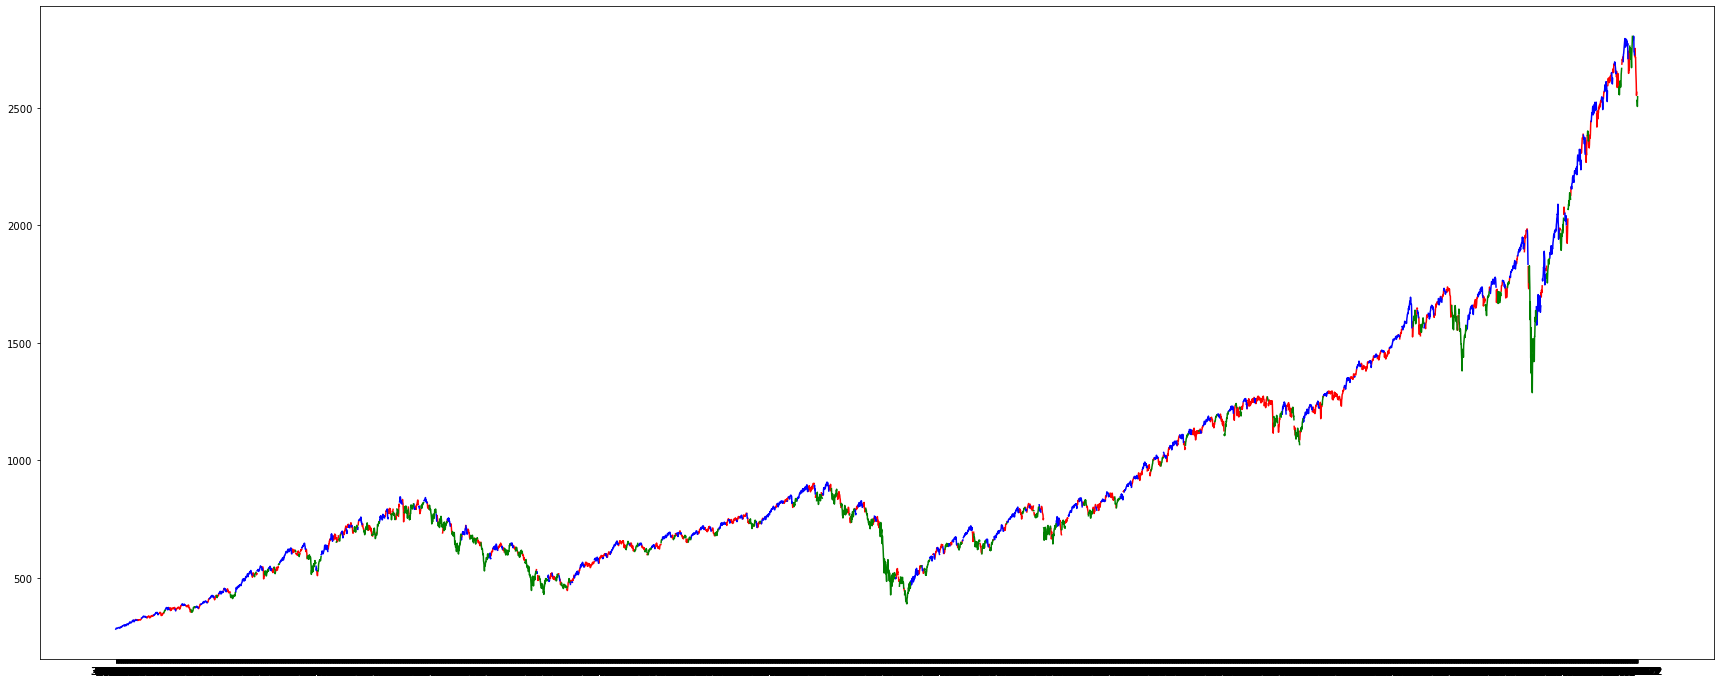

In [49]:
def generate_holdout_sample(return_df : pd.DataFrame, block_size: int) -> tuple:
    _return_vec = np.asarray(return_df)
    X = []
    y = []
    i = 0
    while i < (_return_vec.size - block_size):
        X.append(_return_vec[i:(i+block_size)])
        y.append(_return_vec[i+block_size])
        i += 1
    return np.asarray(X), y

modelName = "final_model"
model_path = os.path.join(".", modelName)
model_test = loadModel(model_path)
data_holdout = get_data_from_csv('RUA', _folder='sample')
y_id = data_holdout.index[22:] # No prediction for the first 22 entries
X_holdout, y_holdout = generate_holdout_sample(data_holdout, 22)
X_holdout = X_holdout.reshape([-1, 22, 1])
y_pred_softmax = model_test.predict(X_holdout)
y_pred_label = np.argmax(y_pred_softmax, axis=1)
x_std = get_std_from_sample(X_holdout)
y_pred_ret = get_returns_from_signal(y_pred_label, y_pred_softmax, x_std)
print(len(y_pred_label))
df_compare = pd.read_csv('Data/sample/RUA.csv', index_col='Dt')
df_compare.dropna(how='any', inplace=True)
df_compare = df_compare[22:]
df_compare['state'] = y_pred_label
print(len(df_compare))
print(df_compare.head)
# Plotting
ret0 = df_compare[df_compare['state'] == 0]['Adj Close']
ret0 = ret0.reindex(df_compare.index)
ret1 = df_compare[df_compare['state'] == 1]['Adj Close']
ret1 = ret1.reindex(df_compare.index)
ret2 = df_compare[df_compare['state'] == 2]['Adj Close']
ret2 = ret2.reindex(df_compare.index)
plt.figure(figsize=(30, 12))
plt.plot(ret0, color='r')
plt.plot(ret1, color='b')
plt.plot(ret2, color='g')
plt.show()

In [24]:
print('Done.')

Done.
